In [38]:
import numpy as np
import matplotlib.pyplot as plt
import time

## Kalman Filter - Intuition

Let's suppose that we want to measure the temperature in the room, but our thermometer is an uncertain one. Whenever we use it, it shows us the temperature with error $\pm 3.5 ^\circ \text{C}$. With suach a poor devie we can only guess what is the real temperature. Fortunately, we can use the Kalman Filter algorithm to find the better approximation of the true value

In [4]:
temperature_real = 32.0

In [5]:
thermometer_err = 3.5

measurements = np.random.normal(loc=temperature_real, scale=thermometer_err, size=50)

<IPython.core.display.Javascript object>


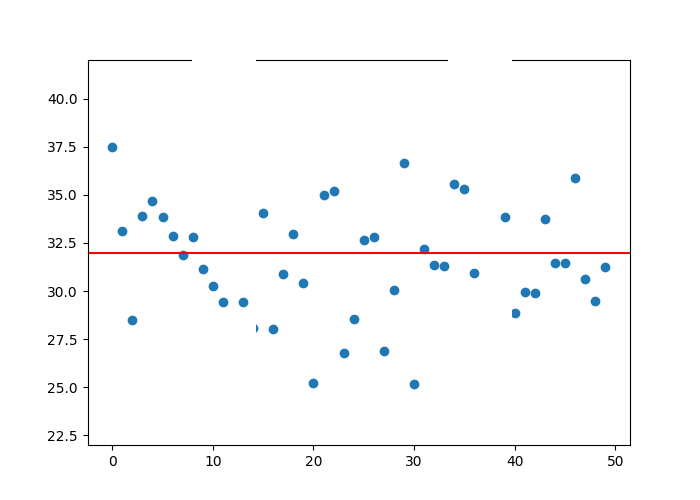

In [6]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(7,5))
ax.set_ylim(temperature_real - 10,temperature_real + 10)
ax.scatter(np.arange(len(measurements)), measurements)
ax.axhline(y=temperature_real, color='r', linestyle='-')

**Kalman Filter** is an **iterative** algorithm that uses a series of measurements observed over time and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone. When using the Kalman Filter we assume, that the measurement sensors are makeing the observations containing the **Gaussian noise**.

It is a **two-step process**, that produces **estimates** of the current **state** variables, along with their uncertainties firstly. Then a **new measurement** is made, which allows us to update our belief about the state and make a better estimation.

![Kalman Filter](KF.jpg)

During the process we produce an estimation based on the previous estimated value and a new measurement. To find a good proportion of these value we calculate the **Kalman Gain**. It is a value in range $(0,1)$ that tells us how much do we prefer our estimations over new measurements based on the **errors** of both. We compute it as:
### $KG = \frac{Err_{est}}{Err_{est}+Err_{mea}}$
where $Err_{est}$ is the error of our estimations and $Err_{mea}$ is the uncertainity of observations made. Then the next estiamted value is computed as:
### $E_t = E_{t-1} + KG \cdot (M_t - E_{t-1})$
Finally, we update the error of our estimations:
### $Err_{est_t} = (1-KG) \cdot Err_{est_{t-1}}$
If the Kalman Gain value is close to one then we can expect, that our predictions are getting more and more accure. If it is close to the 0 then our estimations are much too noisy yet, so the predicted value is going to be determined by the measurement, and the error of the estimation will reduce more slowly.

In [7]:
def kalman_filter_1D(measurements, err_m):
    KG = lambda err_e : err_e / (err_e + err_m)
    
    est = np.empty_like(measurements)
    err_e, kalman_gain = np.copy(est), np.copy(est)
    est[0] = measurements[0]
    err_e[0] = err_m
    kalman_gain[0] = 0.5
    
    for i in range(1, len(measurements)):
        kalman_gain[i] = KG(err_e[i-1])
        est[i] = est[i-1] + kalman_gain[i] * (measurements[i] - est[i-1])
        err_e[i] = (1 - kalman_gain[i]) * err_e[i-1]
    return est, err_e, kalman_gain

In [8]:
est, err_e, kalman_gain = kalman_filter_1D(measurements, thermometer_err)

<IPython.core.display.Javascript object>


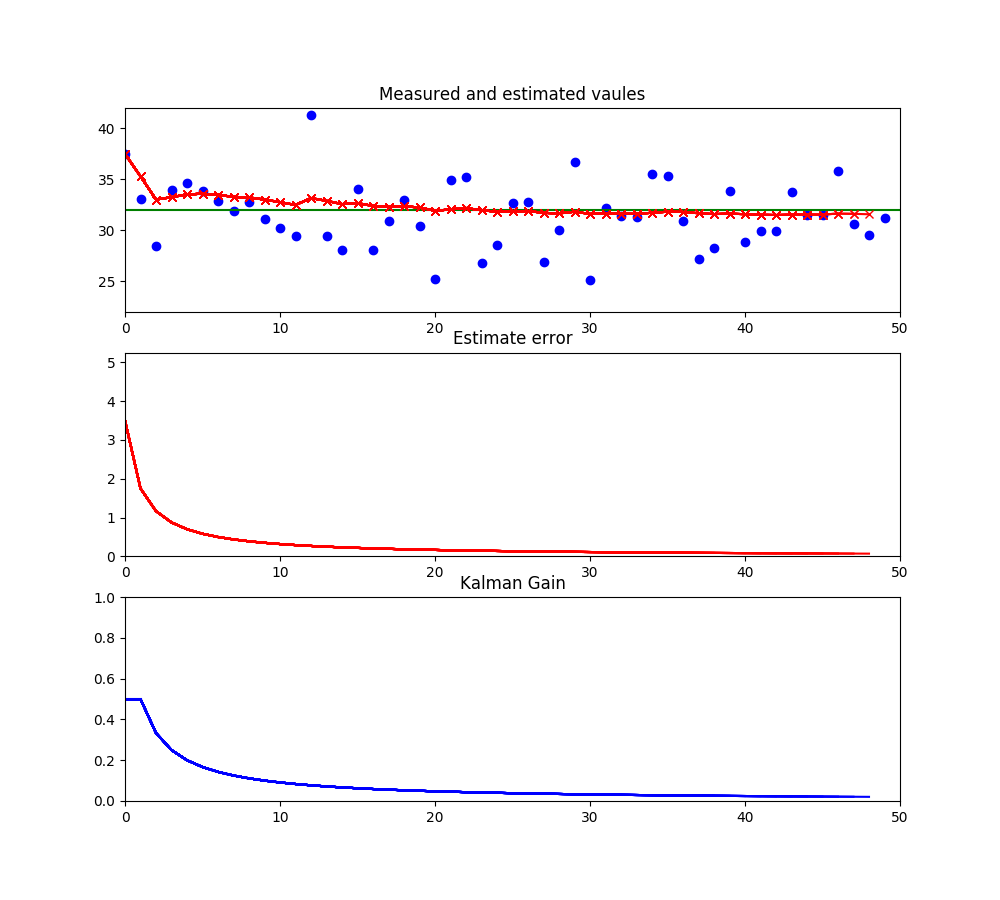

In [10]:
fig, ax = plt.subplots(3,1, figsize=(10,9))

ax[0].set_ylim(temperature_real - 10, temperature_real + 10)
ax[0].set_xlim(0,len(measurements))
ax[1].set_ylim(0, 1.5 * thermometer_err)
ax[1].set_xlim(0,len(measurements))
ax[2].set_ylim(0,1)
ax[2].set_xlim(0,len(measurements))
ax[0].set_title('Measured and estimated vaules')
ax[1].set_title('Estimate error')
ax[2].set_title('Kalman Gain')

ax[0].axhline(y=temperature_real, color='g', linestyle='-')
scale = np.arange(len(est))
for i in range(len(est)):
    ax[0].scatter(i, measurements[i], c='b')
    ax[0].plot(scale[:i], est[:i], '-x', c='r')
    ax[1].plot(scale[:i], err_e[:i], c='r')
    ax[2].plot(scale[:i], kalman_gain[:i], c='b')
    fig.canvas.draw()
    time.sleep(0.5)

## Multidimenstional Kalman Filter

Things are not so easy when we want to estimate something more than just a single number - e.g. the position of an object. Here our state is a vector with object's coordinates. The uncertainty is represented by the _Process Covariance Matrix **P**_. Also Kalman Gain is represented as a matrix, as uncertainty may be different for every entry of the state vector. During iterations we use some error terms, which are also matrices and depends on the nature of the problem we consider, to make the estimations as accure as possible.

![Multidimensional KF](multidim.png)

Let's consider a cyclist motion on a track. The cyclist has a GPS sensor, which measures his position as well as speed and the angular speed with gyroscope.

During a single lap we took 100 observations.

In [11]:
N = 100
t = np.linspace(0, 2*np.pi, N)
dt = t[1] - t[0]

The cyclist position at time $t$ can be represented as $(cos(t),  2 \cdot sin(t))$ Velocity is defined as the rate of change of displacement with respect to time, and acceleration is defined as the rate of change of velocity with respect to time. The third derivative of the motion w.r.t. time is jerk.

In [12]:
motion = np.vstack([np.cos(t), 2*np.sin(t)]).T
velocity = np.vstack([-np.sin(t), 2*np.cos(t)]).T
acc = np.vstack([-np.cos(t), -2*np.sin(t)]).T
jerk = np.vstack([np.sin(t), -2*np.cos(t)]).T

The GPS device is making some disturbed observation.

In [13]:
gps_err = 0.1
speed_err = 0.1
omega_err = 0.2

gps = np.copy(motion)
gps[:,0] += np.random.randn(N) * gps_err
gps[:,1] += np.random.randn(N) * gps_err

Also we need to calculate _speed_ and _angular speed_. They can be obtained as:

$\text{speed} = \sqrt{v_x^2 + v_y^2}$

To obtain the angular speed we need to convert our coordinates to the polar system. The change of the angle $\phi$ can be calculated as:

$\phi = arctan(\frac{v_y}{v_x})$

so the angular speed is the derivative of $\phi$ w.r.t. time, therefore:

### $\omega = \frac{d}{dt}\phi = \frac{v_x\cdot a_y - v_y \cdot a_x}{v_x^2 + v_y^2}$

In [14]:
speed = np.sqrt(np.sum(velocity**2, axis=1))
speed_meter = np.copy(speed) + np.random.randn(N) * speed_err

angular_speed = (velocity[:,0] * acc[:,1] - velocity[:,1] * acc[:,0]) / np.sum(velocity**2, axis=1)
angular_meter = np.copy(angular_speed) + np.random.randn(N) * omega_err

Here is a visualization of the cycilist motion and the GPS signal

<IPython.core.display.Javascript object>


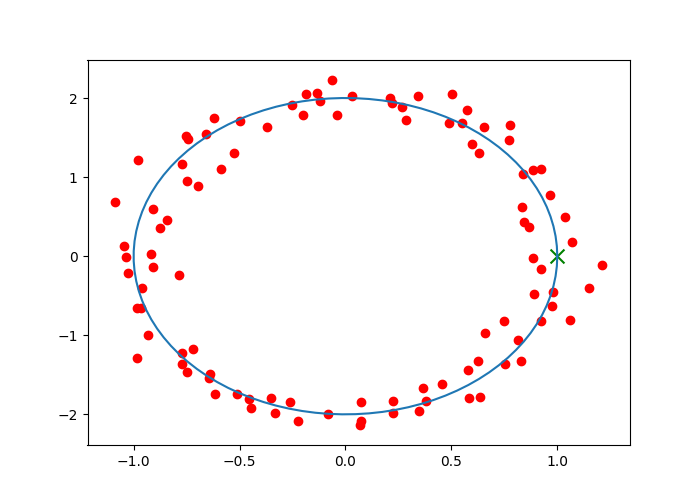

In [15]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(motion[:,0], motion[:,1])
for (x,y) in gps:
    plt.scatter(x,y,c='r')
ax.scatter(*motion[0],marker='x',s=100,c='g')

And the plots of the true and measured speed and angular speed

<IPython.core.display.Javascript object>


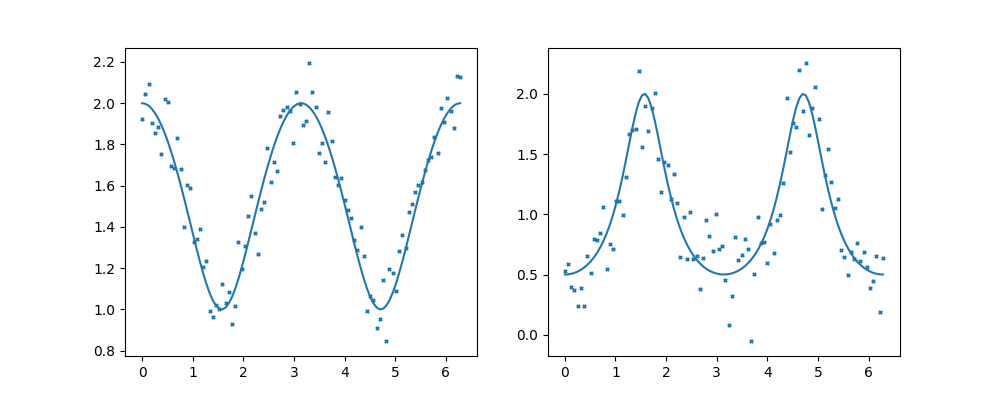

In [16]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(t, speed)
ax[0].scatter(t,speed_meter, marker='x', s=5)
ax[1].plot(t, angular_speed)
ax[1].scatter(t, angular_meter, marker='x', s=5)

Now we need to define our state vector. Firstly let's focus on using the Kalman Filter to obtain more accure GPS position estimation. Our state vector will be defined as:
$\begin{bmatrix} x \\ y \\ v_x \\ v_y \\ a_x \\ a_y \end{bmatrix}$

In [17]:
x_0 = np.array([
    gps[0,0],
    gps[0,1],
    velocity[0,0] + np.random.randn() * gps_err,
    velocity[0,1] + np.random.randn() * gps_err,
    acc[0,0] + np.random.randn() * gps_err,
    acc[0,1] + np.random.randn() * gps_err
])
x_0

array([ 0.9245503 , -0.16082318, -0.11832289,  1.94996458, -0.83169744,
       -0.07072346])

To move from one state to the other we need to contruct the matrix **A**. Based on the physics rules it should convert a state as:

$x^{(t)} = x^{(t-1)} + \Delta t \cdot v_x^{(t-1)} + \frac{\Delta t^2}{2} a_x^{(t-1)}$

$y^{(t)} = y^{(t-1)} + \Delta t \cdot v_y^{(t-1)} + \frac{\Delta t^2}{2} a_y^{(t-1)}$

$v_x^{(t)} = v_x{(t-1)} + \Delta t \cdot a_x^{(t-1)}$

$v_y^{(t)} = v_y{(t-1)} + \Delta t \cdot a_y^{(t-1)}$

$a_x^{(t)} = a_x{(t-1)}$

$a_y^{(t)} = a_y{(t-1)}$

Therefore the A matrix is defined as:

In [18]:
A = np.array([
    [1, 0, dt, 0, (dt**2)/2, 0],
    [0, 1, 0, dt, 0, (dt**2)/2],
    [0, 0, 1, 0, dt, 0],
    [0, 0, 0, 1, 0, dt],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1],
    ])

The _Process Covariance Matrix **P**_ tells us about the uncertainty of our estimations. Here we will assue, that the uncertainty over the dimensions in not dependent, so it will be diagonal matrix with the quantity of the GPS device as a diagonal value.

In [19]:
P = np.eye(6) * gps_err ** 2

The **Q** matrix is representing some possible, unpredicted changes to the state, like the change of the position due to a gust of wind or road bumps. Here we assume, that the possible change of the position could be determied by the variance of the jerk over the move of the cyclist. 

In [21]:
G1 = np.array([(dt**3)/6, 0, (dt**2)/2, 0, dt, 0])[:, None]
G2 = np.array([0, (dt**3)/6, 0, (dt**2)/2, 0, dt])[:, None]
sigma_a = max(np.var(jerk[:,0]), np.var(jerk[:,1]))
Q = sigma_a * (G1.dot(G1.T) + G2.dot(G2.T))

The **R** matrix is the covariance matrix that represents the error of the measurements. Here we will again made it a diagonal matrix, with the varaince of the GPS device uncertainty as a non-zero value

In [22]:
sensor_errors = np.array([gps_err, gps_err])
R = np.diag(sensor_errors) ** 2
R

array([[0.01, 0.  ],
       [0.  , 0.01]])

The **H** matrix is responsible for transforming the state to the estimation. As we want to estimate the position we just need to get the $x$ and $y$ with no changes

In [23]:
H = np.zeros((2,6))
H[0,0] = H[1,1] = 1
H

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

The Kalman Filter algorithm also requires an identity matrix

In [24]:
I = np.eye(H.shape[1])

In [25]:
def kalman_filter(measurements, x_0, P, matrices): 
    A, Q, R, H, I = matrices['A'], matrices['Q'], matrices['R'], matrices['H'], matrices['I']
    
    est = np.empty((measurements.shape[0], x_0.shape[0]))
    est[0] = x_0
    for i in range(1, measurements.shape[0]):
        est[i] = A.dot(est[i-1])
        P = A.dot(P.dot(A.T)) + Q
        
        kalman_gain = P.dot(H.T.dot(np.linalg.inv(H.dot(P.dot(H.T)) + R)))
        est[i] = est[i] + kalman_gain.dot(measurements[i] - H.dot(est[i]))
        P = (I - kalman_gain.dot(H)).dot(P)
    return est

![Kalman Filter Graph](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Kalman_filter_model_2.svg/2880px-Kalman_filter_model_2.svg.png)

In [26]:
matrices = {
    'A' : A,
    'Q' : Q,
    'R' : R,
    'H' : H,
    'I' : I
}
est = kalman_filter(gps, x_0, P, matrices)

Let's see if the estimated values are better than the trace of the GPS measurements

<IPython.core.display.Javascript object>


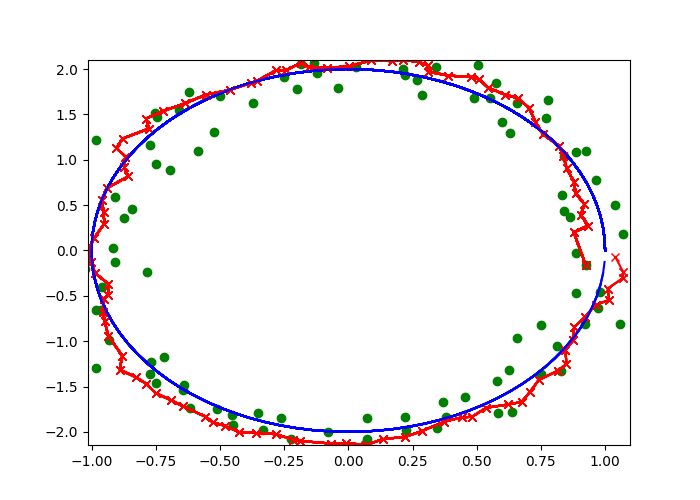

In [27]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim(min(est[:,0]), max(est[:,0]))
ax.set_ylim(min(est[:,1]), max(est[:,1]))
for i, (x,y) in enumerate(gps):
    ax.scatter(x,y,c='g')
    ax.plot(est[:i, 0], est[:i, 1], '-x', c='r')
    ax.plot(motion[:i, 0], motion[:i, 1], c='b')    
    fig.canvas.draw()
    time.sleep(0.05)

The result is definitely better. Please note, that the new route of the cyclist was calculated only with the points measured by the GPS device, we did not use any other information. Therefore we improved the measurements with no additional help.

## Extended Kalman Filter

Unfortunately, we cannot use the Kalman Filter with the speed and the angular speed. All the models we used so far were linear. As the speed and the angular speed have some non-linear relationships with the bike state vector, we are unable to construct a proper matrix **H**

Instead of KF algorithm we must use the Extended Kalman Filter there. It computes the state and the estimation as:

$x^{(t)} = f(x^{(t-1)}) + err^{(t)}$

$y^{(t)} = h(x^{(t)}) + err_y^{(t)}$

Here we will omit the error terms. Moreover the $f$ function is the transition over the state, which remains unchanged and is defined as the matrix A. However to convert the $x^{(t)}$ state to the observation that is calculated with the usage of all three sensors we need to define the **h** non-linear function as:

$h(x^{(t)}) = \begin{bmatrix} 
x \\ 
y \\ 
\frac{v_x\cdot a_y - v_y \cdot a_x}{v_x^2 + v_y^2} \\ 
\sqrt{v_x^2 + v_y^2}  
\end{bmatrix} = \begin{bmatrix} 
x \\ 
y \\ 
\omega \\ 
s
\end{bmatrix} $

In [28]:
def h(state):
    x, y, vx, vy, ax, ay = state
    
    omega = (vx*ay - vy*ax) / (vx**2 + vy**2)
    speed = np.sqrt(vx**2 + vy**2)

    return np.array([x, y, omega, speed])    

While computing the Kalman Gain we need to handle with the process covariance matrix P. As we don't have the H matrix, we need to **approximate** it at each step of the alorithm as the **Jacobian** matrix of the **h** function:

In [29]:
def H(state):
    x, y, vx, vy, ax, ay = state
    denom = vx**2 + vy**2

    do_dvx = (ay*(vy**2 - vx**2) + 2 * vy * ax *vx) / (denom**2)
    do_dax = -vy / denom
    do_dvy = (ax*(vy**2 - vx**2) - 2 * vy * ay *vx) / (denom**2)
    do_day = vx / denom
    ds_dvx = vx / np.sqrt(denom)
    ds_dvy = vy / np.sqrt(denom)

    return np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, do_dvx, do_dvy, do_dax, do_day],
        [0, 0, ds_dvx, ds_dvy, 0, 0],
        ])

As now we are going to use the measurements of all three sensors we need to redefine the **R** matrix.

In [31]:
R = np.diag(np.array([gps_err, gps_err, omega_err, speed_err])) ** 2

In [32]:
R

array([[0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.04, 0.  ],
       [0.  , 0.  , 0.  , 0.01]])

In [33]:
observations = np.hstack([gps, angular_meter[:,None], speed_meter[:,None]])

The algorithm itself is very similar, we just need to take into account new matrices and non-linear nature of the state

In [34]:
def extended_kalman_filter(measurements, x_0, P, matrices): 
    A, Q, R, H, I, h = matrices['A'], matrices['Q'], matrices['R'], matrices['H'], matrices['I'], matrices['h']   
    est = np.empty((measurements.shape[0], x_0.shape[0]))
    est[0] = x_0
    
    for i in range(1, measurements.shape[0]):
        est[i] = A.dot(est[i-1])
        P = A.dot(P.dot(A.T)) + Q
        
        _h = h(est[i])
        _H = H(est[i])
        kalman_gain = P.dot(_H.T.dot(np.linalg.inv(_H.dot(P.dot(_H.T)) + R)))
        est[i] = est[i] + kalman_gain.dot(measurements[i] - _h)
        P = (I - kalman_gain.dot(_H)).dot(P)
    return est

In [35]:
matrices = {
    'A' : A,
    'Q' : Q,
    'R' : R,
    'H' : H,
    'I' : I,
    'h' : h,
}
est = extended_kalman_filter(observations, x_0, P, matrices)

And the estimation of the cyclist motion computed with measurements of all three sensors looks like this:

<IPython.core.display.Javascript object>


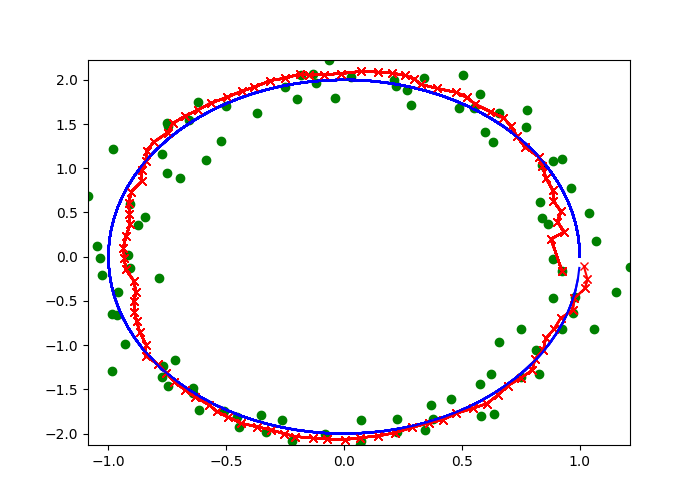

In [36]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlim(min(gps[:,0]), max(gps[:,0]))
ax.set_ylim(min(gps[:,1]), max(gps[:,1]))
for i, (x,y) in enumerate(gps):
    ax.scatter(x,y,c='g')
    ax.plot(est[:i, 0], est[:i, 1], '-x', c='r')
    ax.plot(motion[:i, 0], motion[:i, 1], c='b')    
    fig.canvas.draw()
    time.sleep(0.05)

Moreover, we can use our estimations to obtain new, probably more accure, resluts of the speedometer and the gyroscope

In [298]:
est_transform = np.apply_along_axis(h, 1, est)

<IPython.core.display.Javascript object>


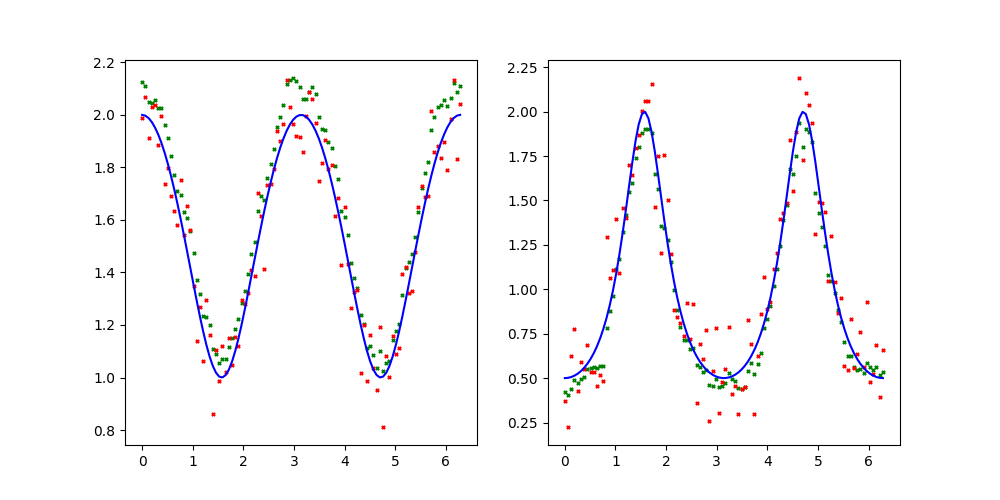

In [313]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(t, speed,c='b')
ax[0].scatter(t,est_transform[:,3], marker='x', s=5, c='g')
ax[0].scatter(t,speed_meter, marker='x', s=5, c='r')
ax[1].plot(t, angular_speed, c='b')
ax[1].scatter(t, est_transform[:,2], marker='x', s=5, c='g')
ax[1].scatter(t, angular_meter, marker='x', s=5, c='R')